# Read/query/write large-ish tables

In this notebook I showcase the manipulation of large tables using `duckdb` and `pandas`, benchmarking different approaches to writing. reading, and querying aggregate quantities from a 1-million-row table containing real astronomical data.

https://gea.esac.esa.int/archive/ -> Search -> Advanced (ADQL)

    SELECT TOP 1000000 l, b, ra, dec, pmra, pmra_error, pmdec, pmdec_error, parallax, parallax_error, radial_velocity, radial_velocity_error, vbroad, phot_g_mean_mag as g, bp_rp, has_xp_continuous, ruwe, non_single_star, astrometric_matched_transits, visibility_periods_used, GAIA_HEALPIX_INDEX(2, source_id) as hpx2, GAIA_HEALPIX_INDEX(5, source_id) as hpx5
    FROM gaiadr3.gaia_source
    ORDER by random_index

I saved the file to disk in CSV format.

In [1]:
%config InlineBackend.figure_format='retina'
import pandas as pd
import os
import matplotlib.pyplot as plt

# pandas and seaborn

In [2]:
%%time
csv_file_name = 'gaia_dr3_lite_random_1M.csv'
df = pd.read_csv(csv_file_name)

CPU times: user 1.53 s, sys: 213 ms, total: 1.74 s
Wall time: 1.74 s


In [3]:
%%time
print('This data set has %i rows and %i columns.' % df.shape )
print('It occupies %.3f MB in memory.' % (df.memory_usage().sum() / 2**20 ))
print('The corresponding CSV file occupies %.3f MB on disk.' % (os.stat(csv_file_name).st_size / 2**20 ))
df.describe().T

This data set has 1000000 rows and 22 columns.
It occupies 161.171 MB in memory.
The corresponding CSV file occupies 196.069 MB on disk.
CPU times: user 681 ms, sys: 73.4 ms, total: 755 ms
Wall time: 753 ms


,count,mean,std,min,25%,50%,75%,max
l,1000000.0,184.560010,135.782534,0.000298,41.665460,208.165550,319.588072,359.999736
b,1000000.0,-1.276671,15.611415,-89.432920,-7.212448,-1.914144,5.493280,89.363414
ra,1000000.0,229.109533,77.756427,0.002566,187.976543,260.160052,280.435545,359.994951
dec,1000000.0,-18.412379,36.544729,-89.574739,-47.245969,-25.710221,6.636795,89.717993
pmra,809921.0,-2.562336,5.514569,-290.913871,-4.798738,-2.513329,-0.349249,264.016994
pmra_error,809921.0,0.505132,0.482461,0.004448,0.157231,0.352046,0.688665,3.351415
pmdec,809921.0,-3.114088,5.622360,-378.674786,-5.614093,-3.106414,-0.315159,340.639839
pmdec_error,809921.0,0.448753,0.428796,0.007219,0.145377,0.314270,0.607966,3.370995
parallax,809921.0,0.365109,1.030103,-31.111798,0.010741,0.306063,0.673917,75.568876
parallax_error,809921.0,0.463161,0.420070,0.008168,0.155063,0.342478,0.641175,4.672944


Visualise pariwise correlations for some selected quantities:

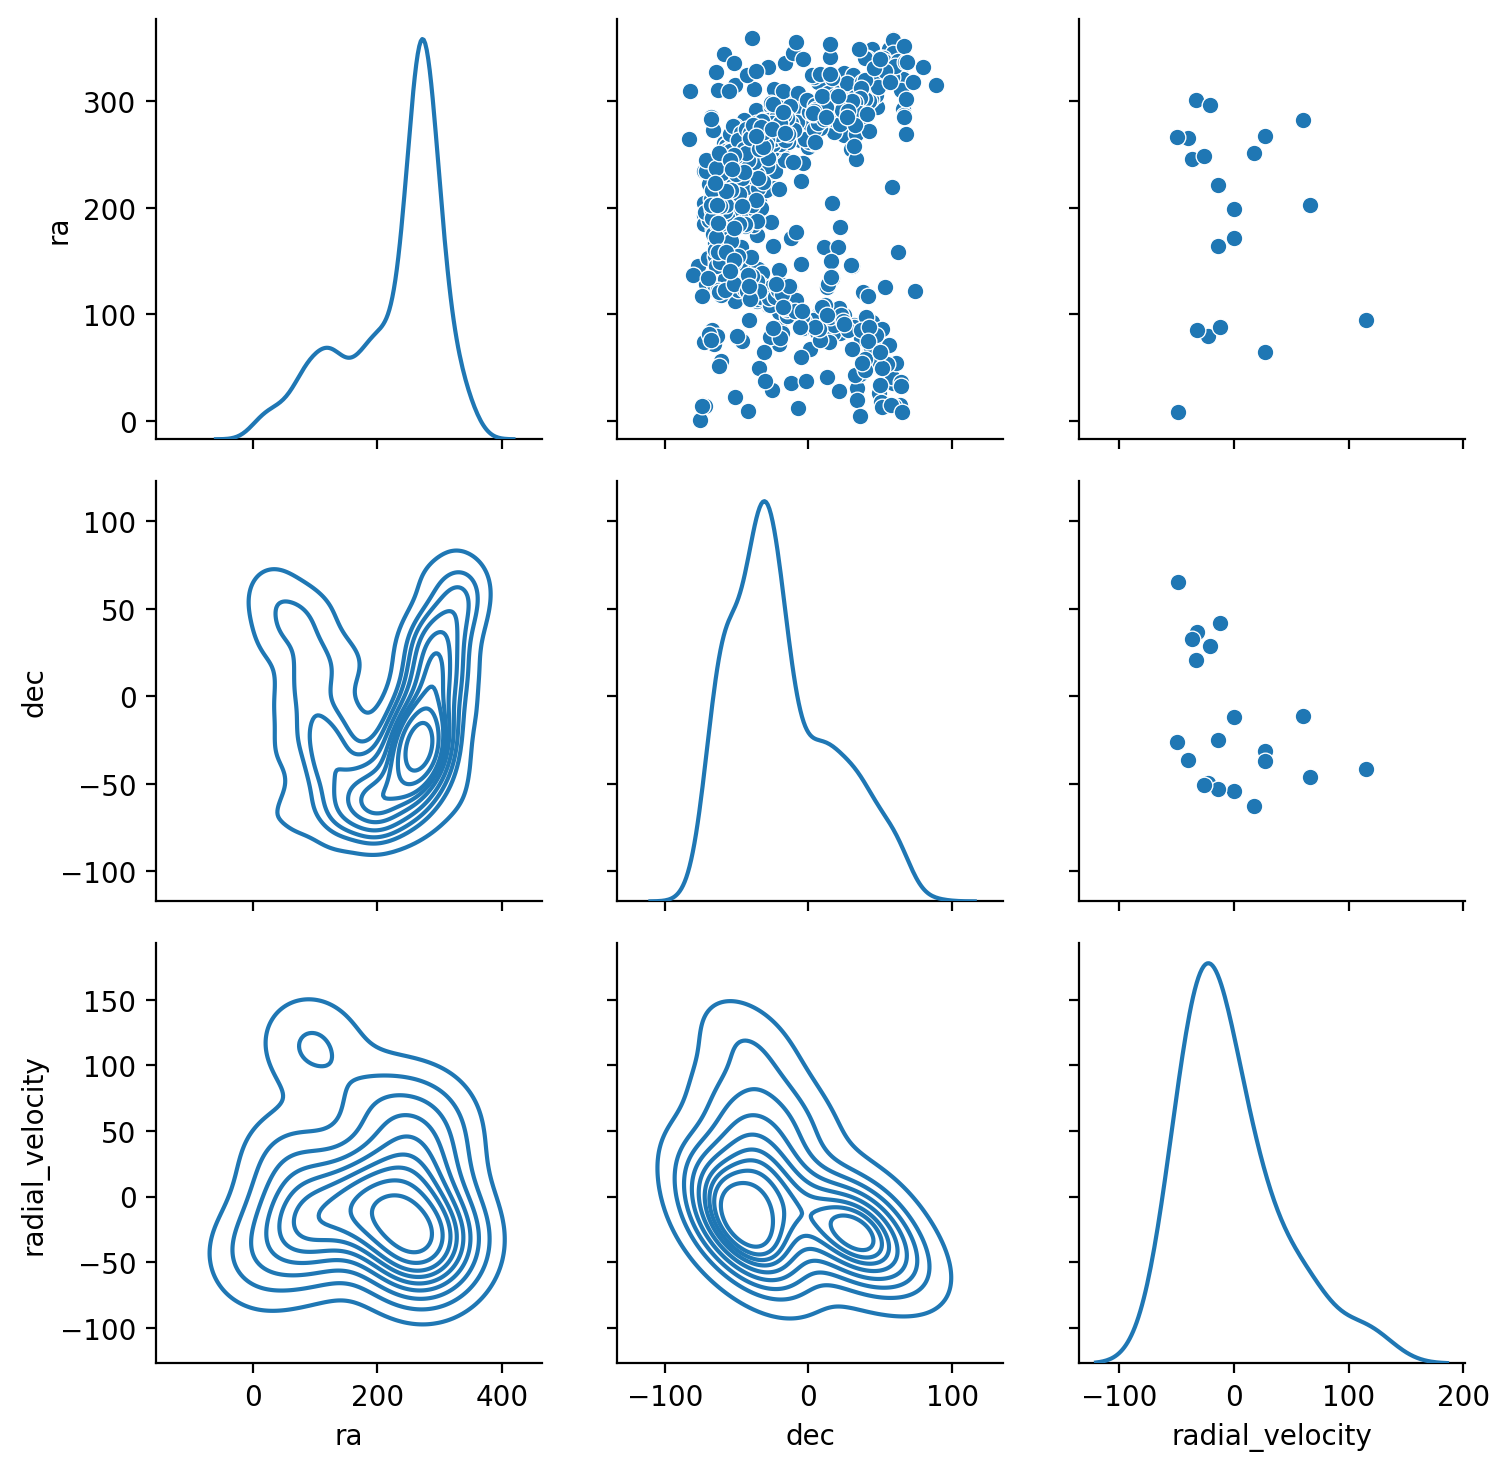

In [4]:
# See https://seaborn.pydata.org/generated/seaborn.PairGrid.html
import seaborn as sns
g = sns.PairGrid(df[['ra','dec','radial_velocity']][:1000], diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot);

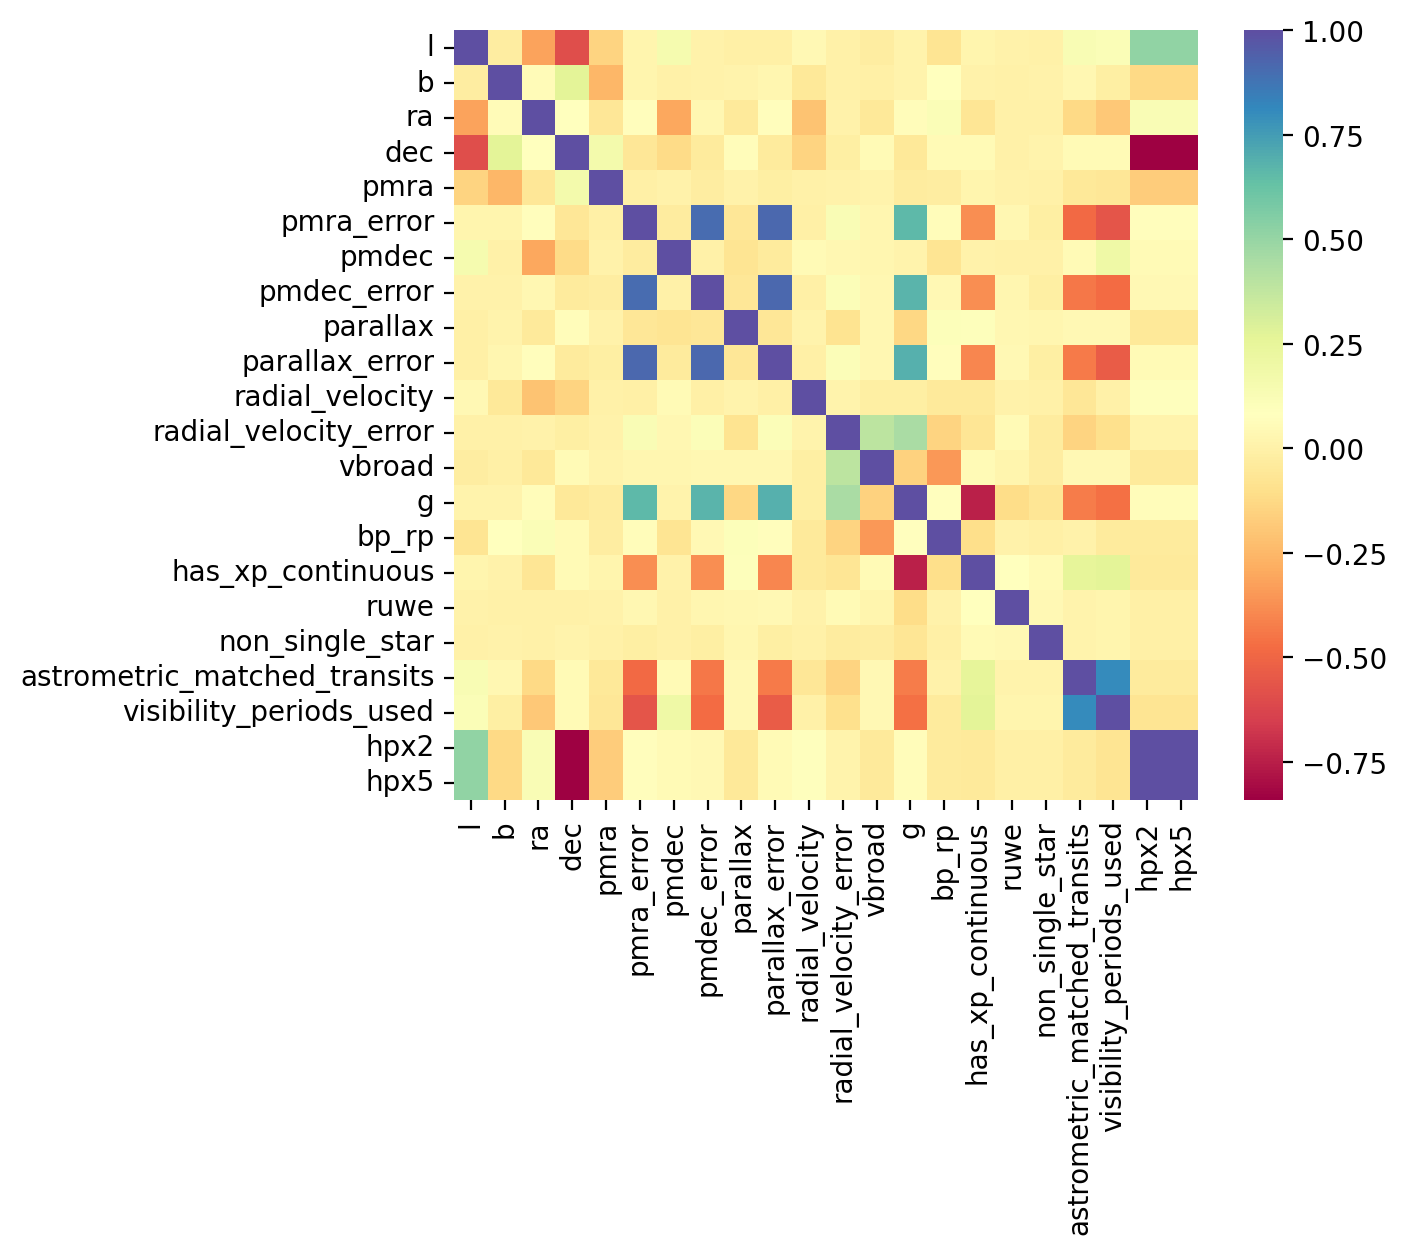

In [5]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), cmap="Spectral", annot=False);

## Aggregate

In [6]:
%%time
df.agg(
  Sum=('l', 'sum'),
  Min=('l', 'min'),
  Max=('l', 'max'),
  Avg=('l', 'mean')
)

CPU times: user 12.5 ms, sys: 1.39 ms, total: 13.9 ms
Wall time: 12.4 ms


,l
Sum,1.845600e+08
Min,2.975066e-04
Max,3.599997e+02
Avg,1.845600e+02


# duckdb on the pandas dataframe

We import duckdb to perform queries on the pandas dataframe. The next section is an adaptation of this showcasing the efficiency of duckdb: https://duckdb.org/2021/05/14/sql-on-pandas.html

Note that another option would be to save our data as a `parquet` file and open it with duckdb, ditching pandas entirely.

In [7]:
import duckdb

## Aggregate

In [8]:
%%time
duckdb.query(
    """SELECT sum(l) as Sum,
       min(l) as Min,
       max(l) as Max,
       avg(l) as Avg
FROM df;"""
).to_df()

CPU times: user 23.4 ms, sys: 2.06 ms, total: 25.5 ms
Wall time: 8.55 ms


,Sum,Min,Max,Avg
0,1.845600e+08,0.000298,359.999736,184.56001


Here duckdb is slightly faster than pandas.

## Grouped aggregate - mean

In [9]:
%%time
df.groupby(
  ['hpx5']
).agg(
  meanL=('l', 'mean'),
  meanB=('b', 'mean'),
  meanPMRA=('pmra', 'mean'),
  meanPMDEC=('pmdec', 'mean')
)

CPU times: user 50.8 ms, sys: 12 ms, total: 62.8 ms
Wall time: 61.1 ms


,meanL,meanB,meanPMRA,meanPMDEC
hpx5,,,,
0.0,175.946247,-48.479329,6.009433,-3.094447
1.0,175.428057,-46.162956,16.423222,-17.684266
2.0,172.721889,-48.420354,1.419328,-4.925885
3.0,173.746097,-46.351328,8.614509,-6.011953
4.0,176.325732,-44.134241,4.918780,-5.167080
...,...,...,...,...
12283.0,43.999793,-27.725749,1.154579,-6.805211
12284.0,45.336669,-30.014719,1.460014,-7.063548
12285.0,47.325015,-30.692795,0.948179,-5.556799


In [10]:
%%time
duckdb.query(
    """SELECT
      hpx5,
      avg(l),
      avg(b),
      avg(pmra),
      avg(pmdec)
FROM df
GROUP BY hpx5
ORDER BY hpx5;"""
).to_df()

CPU times: user 117 ms, sys: 20.5 ms, total: 137 ms
Wall time: 28.3 ms


,hpx5,avg(l),avg(b),avg(pmra),avg(pmdec)
0,0.0,175.946247,-48.479329,6.009433,-3.094447
1,1.0,175.428057,-46.162956,16.423222,-17.684266
2,2.0,172.721889,-48.420354,1.419328,-4.925885
3,3.0,173.746097,-46.351328,8.614509,-6.011953
4,4.0,176.325732,-44.134241,4.918780,-5.167080
...,...,...,...,...,...
12273,12283.0,43.999793,-27.725749,1.154579,-6.805211
12274,12284.0,45.336669,-30.014719,1.460014,-7.063548
12275,12285.0,47.325015,-30.692795,0.948179,-5.556799
12276,12286.0,45.643291,-28.188212,-0.748367,-4.266005


duckdb is twice as fast as pandas

## Grouped aggregate with a filter

pandas 1

In [11]:
%%time
# filter out the rows
filtered_df = df[
  df['g'] < 19 ]
# perform the aggregate
result = filtered_df.groupby(
  ['hpx5']
).agg(
  meanL=('l', 'mean'),
  meanB=('b', 'mean'),
  meanPMRA=('pmra', 'mean'),
  meanPMDEC=('pmdec', 'mean')
)
result

CPU times: user 43.8 ms, sys: 14.4 ms, total: 58.2 ms
Wall time: 56.5 ms


,meanL,meanB,meanPMRA,meanPMDEC
hpx5,,,,
0.0,176.052564,-48.512300,4.152197,-3.171355
1.0,175.049053,-46.539873,16.471995,-29.782183
2.0,172.573851,-48.321296,-1.596701,-2.863112
3.0,173.582645,-46.506441,8.643402,-7.936456
4.0,176.614993,-43.974142,4.918780,-5.167080
...,...,...,...,...
12283.0,44.110221,-27.671976,-1.260311,-4.599668
12284.0,45.556882,-30.068467,4.552269,-3.884345
12285.0,47.259629,-30.806379,0.698713,-6.818143


pandas 2 - filtering out the unnecessary columns

In [12]:
%%time
# alternative: reduce the number of columns before filtering
# projection pushdown
pushed_down_df = df[
  ['l',
   'b',
   'pmra',
   'pmdec',
   'g',
   'hpx5']
]
# perform the filter
filtered_df = pushed_down_df[
  pushed_down_df['g'] < 19 ]
# perform the aggregate
result = filtered_df.groupby(
  ['hpx5']
).agg(
  meanL=('l', 'mean'),
  meanB=('b', 'mean'),
  meanPMRA=('pmra', 'mean'),
  meanPMDEC=('pmdec', 'mean')
)
result

CPU times: user 36.6 ms, sys: 14.7 ms, total: 51.4 ms
Wall time: 49.7 ms


,meanL,meanB,meanPMRA,meanPMDEC
hpx5,,,,
0.0,176.052564,-48.512300,4.152197,-3.171355
1.0,175.049053,-46.539873,16.471995,-29.782183
2.0,172.573851,-48.321296,-1.596701,-2.863112
3.0,173.582645,-46.506441,8.643402,-7.936456
4.0,176.614993,-43.974142,4.918780,-5.167080
...,...,...,...,...
12283.0,44.110221,-27.671976,-1.260311,-4.599668
12284.0,45.556882,-30.068467,4.552269,-3.884345
12285.0,47.259629,-30.806379,0.698713,-6.818143


duckdb

In [13]:
%%time
duckdb.query(
    """SELECT
      hpx5,
      avg(l),
      avg(b),
      avg(pmra),
      avg(pmdec)
FROM df
WHERE g < 19
GROUP BY hpx5
ORDER BY hpx5;"""
).to_df()

CPU times: user 78.4 ms, sys: 17.7 ms, total: 96.1 ms
Wall time: 23.1 ms


,hpx5,avg(l),avg(b),avg(pmra),avg(pmdec)
0,0.0,176.052564,-48.512300,4.152197,-3.171355
1,1.0,175.049053,-46.539873,16.471995,-29.782183
2,2.0,172.573851,-48.321296,-1.596701,-2.863112
3,3.0,173.582645,-46.506441,8.643402,-7.936456
4,4.0,176.614993,-43.974142,4.918780,-5.167080
...,...,...,...,...,...
11928,12283.0,44.110221,-27.671976,-1.260311,-4.599668
11929,12284.0,45.556882,-30.068467,4.552269,-3.884345
11930,12285.0,47.259629,-30.806379,0.698713,-6.818143
11931,12286.0,45.594386,-28.359635,-1.394052,-2.486538


# Save full dataframe in various file formats

In [14]:
import time
saved_files = {}

In [15]:
%%time
time_start = time.time()
fname = 'gaia_dr3.parquet'
df.to_parquet(fname)
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 97 MB 
CPU times: user 492 ms, sys: 37.7 ms, total: 530 ms
Wall time: 457 ms


In [16]:
%%time
time_start = time.time()
fname = 'gaia_dr3.parquet.gzip'
df.to_parquet(fname,compression='gzip')
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 89 MB 
CPU times: user 3.63 s, sys: 26.9 ms, total: 3.65 s
Wall time: 3.58 s


In [17]:
%%time
time_start = time.time()
fname = 'gaia_dr3.csv'
df.to_csv(fname)
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 201 MB 
CPU times: user 12.7 s, sys: 203 ms, total: 12.9 s
Wall time: 13 s


In [18]:
%%time
time_start = time.time()
fname = 'gaia_dr3.h5'
df.to_hdf(fname, key='df', mode='w') # default complevel=0
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 168 MB 
CPU times: user 113 ms, sys: 129 ms, total: 241 ms
Wall time: 282 ms


In [19]:
%%time
time_start = time.time()
fname = 'gaia_dr3_comp2.h5'
df.to_hdf(fname, key='df', mode='w', complevel=2) 
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 102 MB 
CPU times: user 3.58 s, sys: 111 ms, total: 3.69 s
Wall time: 3.71 s


In [20]:
%%time
time_start = time.time()
fname = 'gaia_dr3_comp5.h5'
df.to_hdf(fname, key='df', mode='w', complevel=5) 
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 100 MB 
CPU times: user 5.34 s, sys: 103 ms, total: 5.44 s
Wall time: 5.47 s


In [21]:
%%time
time_start = time.time()
fname = 'gaia_dr3.pkl'
df.to_pickle(fname)
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 161 MB 
CPU times: user 1.38 ms, sys: 41.4 ms, total: 42.8 ms
Wall time: 54.4 ms


In [22]:
%%time
time_start = time.time()
fname = 'gaia_dr3_gzip.pkl'
df.to_pickle(fname,compression='gzip')
write_time = time.time()-time_start
file_size = os.stat(fname).st_size / 2**20
saved_files[fname] = {'write_time_s':write_time,'file_size_MB':file_size}
print('File size %i MB ' % (file_size ))

File size 88 MB 
CPU times: user 29.9 s, sys: 107 ms, total: 30 s
Wall time: 30.1 s


# Read back using pandas

Not shown here but also an option: reading files in chunk if they are too large for memory. Pandas can read CSV, parquet (with `engine='fastparquet'`, not sure about `pyarrow`), and HDF files in chunks.

e.g. https://acepor.github.io/2017/08/03/using-chunksize/

In [23]:
for fname in saved_files.keys():
    time_start = time.time()
    
    if fname.endswith('.csv'):
        newdf = pd.read_csv(fname)
    elif '.parquet' in fname:
        newdf = pd.read_parquet(fname)
    elif fname.endswith('.h5'):
        newdf = pd.read_hdf(fname)
    elif fname.endswith('gzip.pkl'):
        newdf = pd.read_pickle(fname,compression='gzip')
    elif fname.endswith('.pkl'):
        newdf = pd.read_pickle(fname)
        
    read_time = time.time()-time_start
    print(fname)
    saved_files[fname]['read_time_s'] = read_time

gaia_dr3.parquet
gaia_dr3.parquet.gzip
gaia_dr3.csv
gaia_dr3.h5
gaia_dr3_comp2.h5
gaia_dr3_comp5.h5
gaia_dr3.pkl
gaia_dr3_gzip.pkl


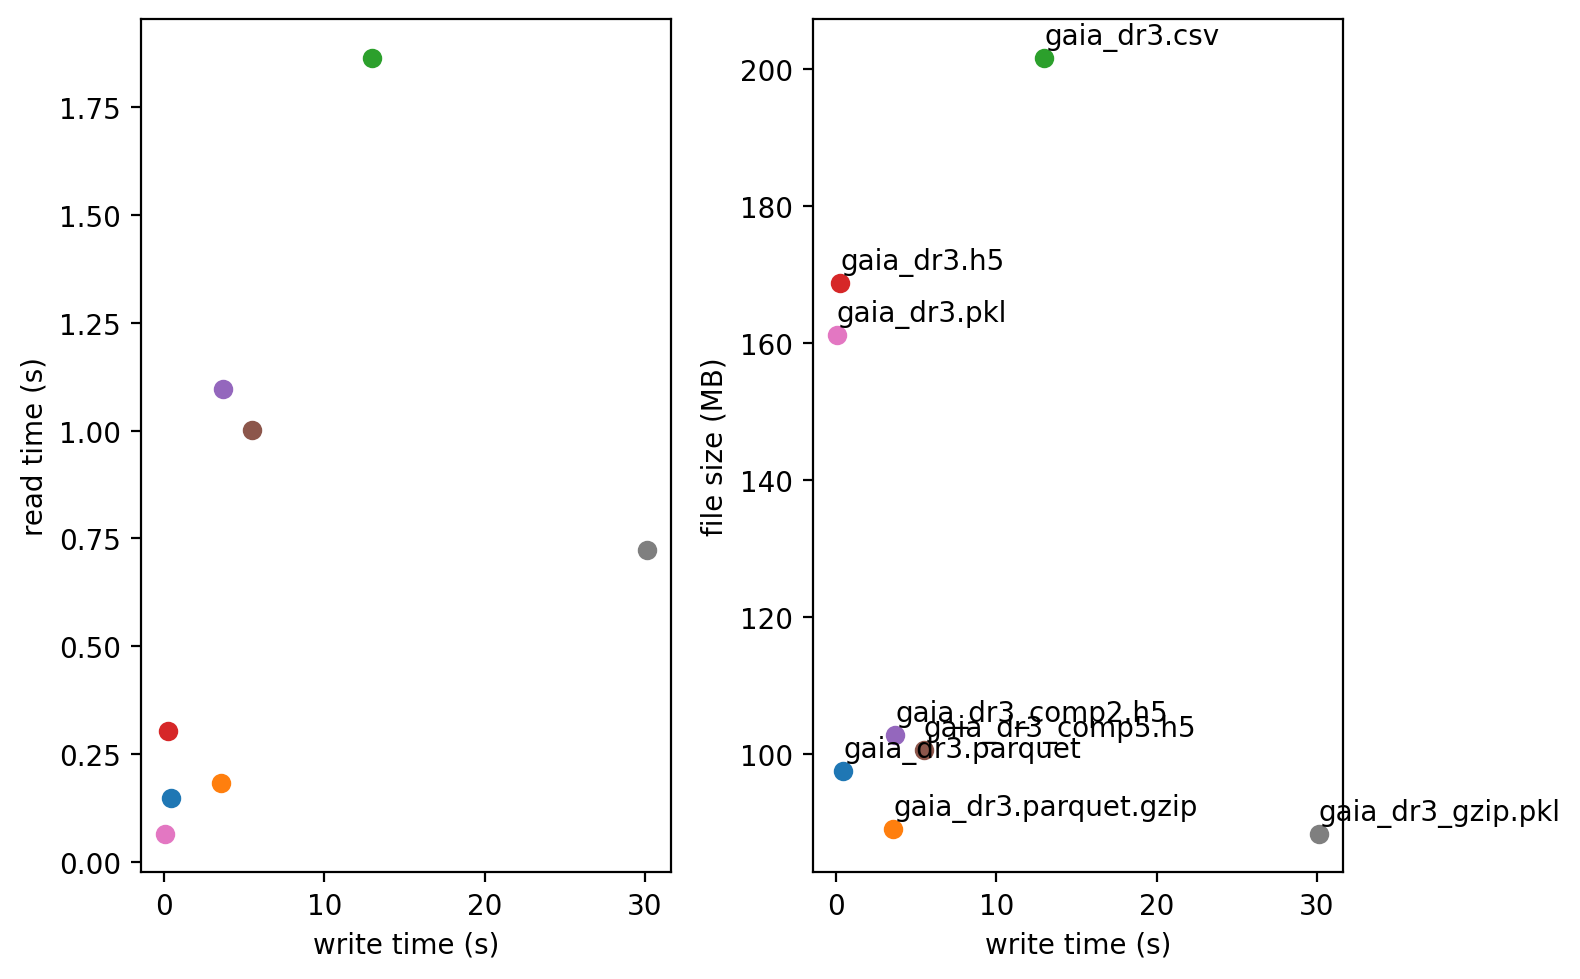

In [24]:
plt.figure(figsize=(8,5))

plt.subplot(121)
for fname in saved_files.keys():
    plt.scatter( saved_files[fname]['write_time_s'], saved_files[fname]['read_time_s'])
plt.xlabel('write time (s)')
plt.ylabel('read time (s)')

plt.subplot(122)
for fname in saved_files.keys():
    plt.scatter( saved_files[fname]['write_time_s'], saved_files[fname]['file_size_MB'])
    plt.text( saved_files[fname]['write_time_s'], saved_files[fname]['file_size_MB']+2 , fname )
plt.xlabel('write time (s)')
plt.ylabel('file size (MB)')

plt.tight_layout();

Parquet: fast to read, fast to write without compression, small file size (even without compression).

HDF5: fast to write and okay to read but huge files. Supports compression but then becomes slow to write.

CSV: worst performance by all three metrics

Pickle: faster read/write, huge file size (still better than uncompressed HDF5 by all metrics). Can be compressed (pandas has many options) but then read time is meh and write time is by far the worst.

# Reading time using duckDB only

DuckDB can read parquet files with default compression (snappy, not gzip) and CSV files (including gzipped ones). It is much faster than pandas, as long as you don't materialise the result as a pandas dataframe. On this dataset, duckdb->pandas is still faster than pandas on the uncompressed CSV file.

See more about I/O with duckDB: https://duckdb.org/docs/data/overview

In [25]:
%%time
duckdb.query(
    """SELECT * FROM gaia_dr3.parquet;"""
)

CPU times: user 595 µs, sys: 169 µs, total: 764 µs
Wall time: 776 µs


┌────────────────────┬─────────────────────┬────────────────────┬───┬──────────────────────┬────────┬─────────┐
│         l          │          b          │         ra         │ … │ visibility_periods…  │  hpx2  │  hpx5   │
│       double       │       double        │       double       │   │        int64         │ double │ double  │
├────────────────────┼─────────────────────┼────────────────────┼───┼──────────────────────┼────────┼─────────┤
│ 34.939057681080605 │  -3.306331530100472 │  286.7169128963743 │ … │                   15 │  118.0 │  7580.0 │
│ 286.53234598700635 │  -6.648696094333302 │ 152.62506770596002 │ … │                   10 │  145.0 │  9330.0 │
│ 104.93518397291662 │ -15.490522969667488 │  348.4349822143073 │ … │                   23 │   53.0 │  3442.0 │
│  346.0966503785344 │   4.141483160590423 │  252.7297169379439 │ … │                   16 │  165.0 │ 10607.0 │
│ 344.19002179776265 │  -4.748318303495822 │  260.6787873092191 │ … │                   19 │  165.0 │ 10

In [26]:
%%time
duckdb.query(
    """SELECT * FROM read_csv(gaia_dr3.csv);"""
)

CPU times: user 94.9 ms, sys: 27.7 ms, total: 123 ms
Wall time: 122 ms


┌──────────┬────────────────────┬─────────────────────┬───┬──────────────────────┬────────┬─────────┐
│ column00 │         l          │          b          │ … │ visibility_periods…  │  hpx2  │  hpx5   │
│  int64   │       double       │       double        │   │        int64         │ double │ double  │
├──────────┼────────────────────┼─────────────────────┼───┼──────────────────────┼────────┼─────────┤
│        0 │ 34.939057681080605 │  -3.306331530100472 │ … │                   15 │  118.0 │  7580.0 │
│        1 │ 286.53234598700635 │  -6.648696094333302 │ … │                   10 │  145.0 │  9330.0 │
│        2 │ 104.93518397291662 │ -15.490522969667488 │ … │                   23 │   53.0 │  3442.0 │
│        3 │  346.0966503785344 │   4.141483160590423 │ … │                   16 │  165.0 │ 10607.0 │
│        4 │ 344.19002179776265 │  -4.748318303495822 │ … │                   19 │  165.0 │ 10575.0 │
│        5 │   334.929012788207 │   17.42902715002757 │ … │                    6 │